## DSGE w. Feedback - Numerical Simulations

### Imports

In [1]:
%matplotlib notebook
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
%aimport


Modules to reload:
all-except-skipped

Modules to skip:



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
import steadystate
import model
import graphs

-----
# Rebuilding Investment Based on Sharpe Ratio

Calculation of the sentiment
1. Modify the returns on capital by (1 - $\xi_q$) such that $\xi_q\sim Beta(a_t,1)$, $a_t=10\frac{k_t}{n_t}$
2. The household invests based on its own portfolio observation: <br>
   The portfolio return can be described by
   
   \begin{equation}
       r_{p,t} = \frac{b_t}{b_t+k_t}r + \frac{k_t}{b_t+k_t}\xi_{q,t}q_t
   \end{equation}<br>

3. Based on these portfolio returns, the household generates a future expectation on the basis of:
    \begin{eqnarray}
        \mu_{q,t} &=& \alpha\mu_{q,t-1} + (1 - \alpha) r_{p,t} \\
        \sigma^2_{q,t} &=& \alpha\sigma^2_{q,t-1} + (1 - \alpha) r^2_{p,t}
    \end{eqnarray}
    where $\alpha$ is the memory parameter, i.e. how much the household cares about the past (a form of inertia) / how little hysteria
    
4. Finally, the household considers an investment signal
    \begin{eqnarray}
        \mathcal{I}_r &=& (r - \mu_{q,t})\sigma_{q,t}^{-1}\\
    \end{eqnarray}
    that is positive when the household should invest in bonds ($s\rightarrow1$) and negative when the household should invest more into stocks ($s\rightarrow0$).<br>
    
5. The allocation is then normalised via:
    \begin{eqnarray}
        s_t &=& \frac12 \left[(s_{\max} - s_{\min})\cdot \tanh\left(\Theta_s s_{t}^0\right) + s_{\min} + s_{\max}\right]
    \end{eqnarray}

In [240]:
def step(t: float, x: np.ndarray, p: dict, err:float):
    """Iteration of one step in the simulation
    
    Parameters
    ----------
    t : float
        Current timestep t
    x : np.ndarray
        state variables z, c, n, b, w, k, q, g, s, news, inc, xiz, xin
    p : dict
        Parameters from simulation
        
    Returns
    -------
    bound : float
        Upper bound on consumption
    """
    # Variables for the simulation
    z_, xiz_, c_, n_, b_, w_, k_, m_, k__, q_, g_, s_, s0_, mu_, sig2_ = x
        
    # Random technology process
    rand = np.random.normal(0, p['sigmaZ'])
    xiz = p['etaZ'] * xiz_ + np.sqrt(1 - p['etaZ'] ** 2) * rand
    z = p['zbar'] * np.exp(xiz)

    # Determine Consumption
    c = model.bisection(z, g_, k_, p)
    
    # Working hours via market clearing
    n = ((c / z) ** (-1 * p['mu']) - p['alpha'] * k_ ** (-1 * p['mu']))
    n = (n / (1 - p['alpha'])) ** (-1 / p['mu'])
    
    # Firm observes desired working hours, sets the wage accordingly
    rho = -1 * p['mu']
    temp = (p['alpha'] * k_ ** rho + (1 - p['alpha']) * n ** rho) 
    temp = temp ** ((1 / rho) - 1)
    w = (1 - p['alpha']) * z * temp * (n ** (rho - 1))
        
    # Income
    income = w * n + (b_  + q_ * k__) / (1 + p['inflation'])
    m = g_ * income - c 
    
    # Investment & Bonds
    investment = income * (1 - g_)
    b = (1 + p['interest']) * s_ * investment
    
    # Capital & Risky return
    k = (1 - p['depreciation']) * k_ + (investment * (1 - s_))
    temp = (p['alpha'] * k ** rho + (1 - p['alpha']) * n ** rho) 
    temp = temp ** ((1 / rho) - 1)
    q = p['alpha'] * z * temp * k ** (rho - 1)
    
    # Returns to the household's portfolio
    w_b = b_ / (b_ + k__)
    port_ret = w_b * p['interest'] + (1 - w_b) * q_
    
    # Expectations are based on EWMA (returns and volatility)
    mu = p['s_alpha'] * mu_ + (1 - p['s_alpha']) * port_ret
    sig2 = p['s_alpha'] * sig2_ + (1 - p['s_alpha']) * (port_ret ** 2)
    
    # Risk-weighted excess returns are the signal
    s0 = (p['interest'] - mu) / np.sqrt(sig2) 
    
    # Decision on Spending and Investment Allocation
    g = g_
    signal = p['s_theta'] * s0 
    s = 0.5 * ((p['s_max'] - p['s_min']) * np.tanh(signal) + p['s_max'] + p['s_min'])
    
    a = 20 * (k / n)
    q = (1 - np.random.beta(a=a, b=1)) * q
        
    return z, xiz, c, n, b, w, k, m, k_, q, g, s, s0, mu, sig2

# TO CHANGE THE STEP DO NOT CHANGE THE RETURN VARIABLES

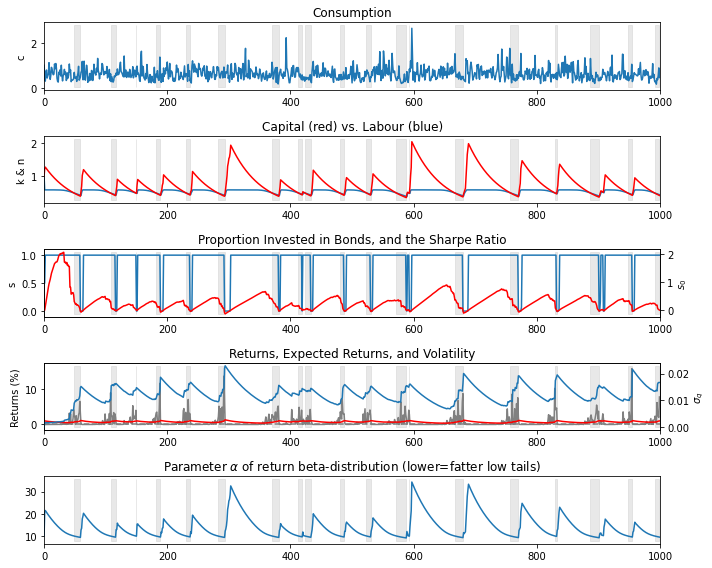

In [251]:
params = {'etaZ': 0.2, 'sigmaZ': 0.4, 'zbar': 1.0,
          'inflation': 0.01, 'interest': 0.01, 'depreciation': 0.02, 
          's_min': 1e-4, 's_max': 1-1e-4,'s_theta':1e3, 's_alpha':0.97,
          'gamma': 1.0, 'alpha': 0.33, 'mu': 12.32}

start = dict(z=1, xiz=1, c=1, n=1, b=1, w=1, k=1, m=0.0, k_=0.0, q=0.02, g=0.7, s=0.5, s0=0.0, mu=0.01, sig2=1e-10)

T = 1000
np.random.seed(40)
view = (0,T)

df = model.simulate(start, params, step_func=step, t_end=T, err = 1e-20)

df.loc[:, 'crisis'] = 0.5 * (1.0 + np.sign(df.n - df.k))
df.loc[:, 'inv'] = 100 * (1-df.loc[:,'g'])
df.loc[:,'bc'] = df.b / df.c
df.loc[:,'utility'] = np.log(df.c) - params['gamma'] * (df.n ** 2)

df = df.iloc[view[0]:view[1],:]

plots = {
        'ln Consumption & Capital' : [df.loc[:,['c','k']], True],
        'Sentiment' : [df.s, False],
        'ln Labour' : [df.loc[:,['n','k']], True],
        'ln Wages' : [df.w, True],
        'M' : [df.m, False],
        'Crisis' : [df.crisis, False],
        'ln Capital' : [df.loc[:,['k']], True],
        'ln Returns' : [df.q, True],
    }


fig, ax = plt.subplots(nrows=5, ncols=1)
ax[0].plot(df.c, label='c')
ax[0].set_ylabel('c')
ax[0].set_title('Consumption')

ax[1].plot(df.n, label='n')
ax[1].plot(df.k, label='k', color='red')
ax[1].set_ylabel(r'k & n')
ax[1].set_title('Capital (red) vs. Labour (blue)')

ax[2].plot(df.s, label='s')
ax[2].set_ylabel(r's')
a = ax[2].twinx()
a.plot(df.s0, color='red')
a.set_ylabel(r'$s_0$')
ax[2].set_title('Proportion Invested in Bonds, and the Sharpe Ratio')

ax[3].axhline(params['interest'], color='gray', linestyle='--')
ax[3].plot(100*df.q, label='q', color='gray')
ax[3].plot(100*df.mu, label='mu', color='red')
ax[3].set_ylabel('Returns (%)')
a = ax[3].twinx()
a.plot(np.sqrt(df.sig2), label='sig')
a.set_ylabel(r'$\sigma_q$')
ax[3].set_title('Returns, Expected Returns, and Volatility')

ax[4].set_title(r'Parameter $\alpha$ of return beta-distribution (lower=fat low tails)')
ax[4].plot(10 * (df.k / df.n))

for a in ax:
    low,high = a.get_ylim()
    a.fill_between(range(df.shape[0]), low, high, where=df.n>df.k, alpha=0.5, color='lightgray')
    a.set_xlim(0, df.shape[0])

fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

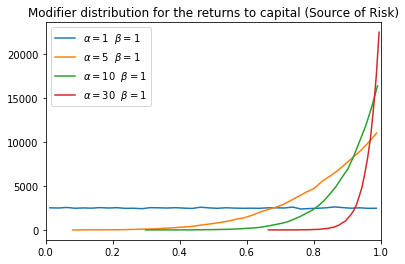

In [271]:
fig, ax = plt.subplots()
ax.set_title('Modifier distribution for the returns to capital (Source of Risk)')
combos = [(1,1), (5,1), (10,1), (30,1)]
for c in combos:
    name = r'$\alpha=${:.0f}  $\beta=${:.0f}'.format(*c)
    n,x = np.histogram(np.random.beta(a=c[0], b=c[1], size=100000), bins = 40)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax.plot(bin_centers, n, label=name)
    #ax.hist(np.random.beta(a=c[0], b=c[1], size=100000), bins=40, alpha=0.5, label=name)

ax.set_xlim(0,1)
plt.legend()
plt.show()